In [1]:
from __future__ import division
from ADMCode import visualize as vis
from ADMCode import ddm, sdt

import numpy as np
import pandas as pd
import numba as nb
from numba.decorators import jit
from numba import float64, int64, vectorize, boolean

from ipywidgets import interactive
from IPython.display import display, Latex
%matplotlib inline
# from safaribook import safariplot as splot
# splot.style('safari-day')

# Signal Detection Theory

In [2]:
interactive_plot = interactive(vis.sdt_interact, Hits=(1,100,1), Misses=(1,100,1), CR=(1,100,1), FA=(1,100,1))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot

interactive(children=(IntSlider(value=100, description='Hits', min=1), IntSlider(value=100, description='Misses', min=1), IntSlider(value=100, description='CR', min=1), IntSlider(value=1, description='FA', min=1), Output(layout=Layout(height='300px'))), _dom_classes=('widget-interact',))

# Drift-Diffusion Model

In [3]:
@jit(nb.typeof((1.0, 1.0))(float64[:], float64[:], float64[:]), nopython=True)
def sim_ddm_trace(rProb, trace, parameters):

    a, tr, v, z, si, dx, dt = parameters

    vProb = .5 * (1 + (v * np.sqrt(dt))/si)
    zStart = z * a

    evidence = zStart
    trace[0] = evidence
    deadline = trace.size

    for nsteps in range(1, deadline):
        if rProb[nsteps] < vProb:
            evidence += dx
        else:
            evidence -= dx
        trace[nsteps] = evidence

        if evidence >= a:
            return tr + (nsteps * dt), 1.0
        elif evidence <= 0:
            return tr + (nsteps * dt), 0.0

    return -1.0, -1.0


# Define Parameters

In [72]:
a = .15 # boundary height
v = .24 # strong drift-rate
v2 = -.12 # weak drift-rate for comparison 
tr = .25 # nondecision time (in seconds)
z = .5 # starting point ([0,1], fraction of a)

dt = .001 # time step
si = .1 # sigma (noise scalar)
deadline = 1.75 # max decision time

ntrials = 750 # number of trials to simulate
data = np.zeros((ntrials, 2)) # empty matrix Ntrials x 2 (cols for RT & Choice)
data2 = np.zeros((ntrials, 2)) # empty matrix Ntrials x 2 (cols for RT & Choice)

In [73]:
parameters, rProb, traces = ddm.gen_ddm_storage_objects(a, tr, v, z, si=si, dt=dt, 
                                           ntrials=ntrials, deadline=deadline)

In [74]:
parameters2, rProb2, traces2 = ddm.gen_ddm_storage_objects(a, tr, v2, z, si=si, dt=dt, 
                                           ntrials=ntrials, deadline=deadline)

# Run Simulations

In [75]:
ddm.sim_ddm_trials(parameters, data, rProb, traces)
ddm.sim_ddm_trials(parameters2, data2, rProb, traces2)

## Filter Output Data

In [76]:
df, trace = ddm.clean_output(data, traces, deadline=deadline)
df2, trace2 = ddm.clean_output(data2, traces2, deadline=deadline)

## Plot simulations

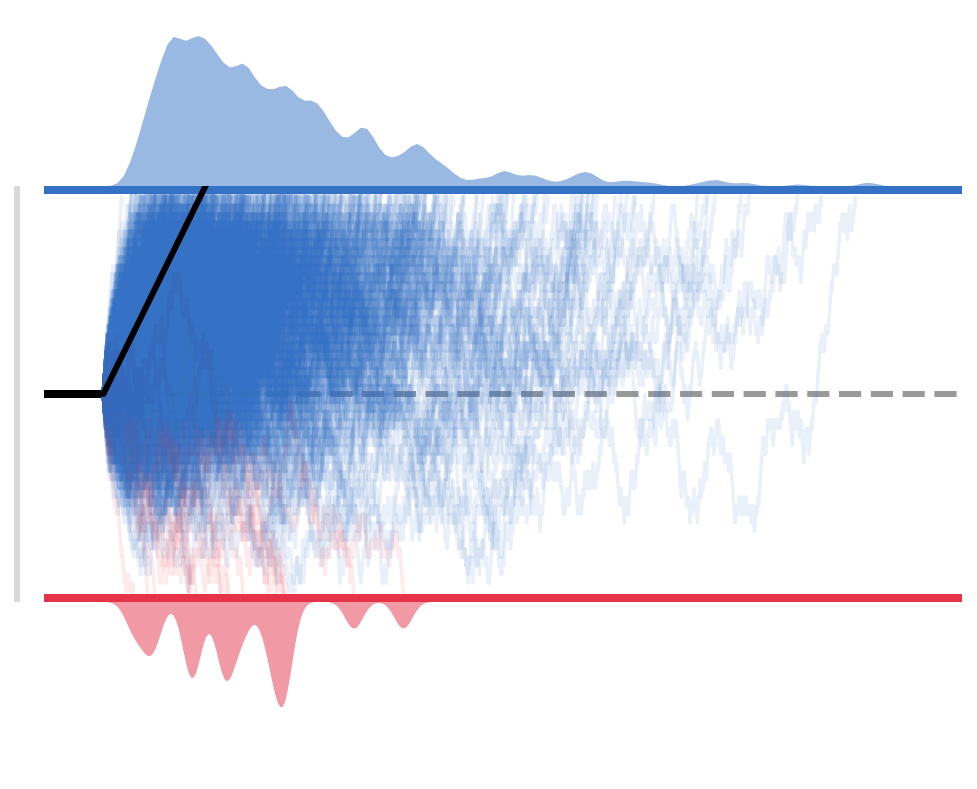

In [107]:
ax = vis.plot_ddm_sims(df, parameters, traces=trace, plot_v=True)

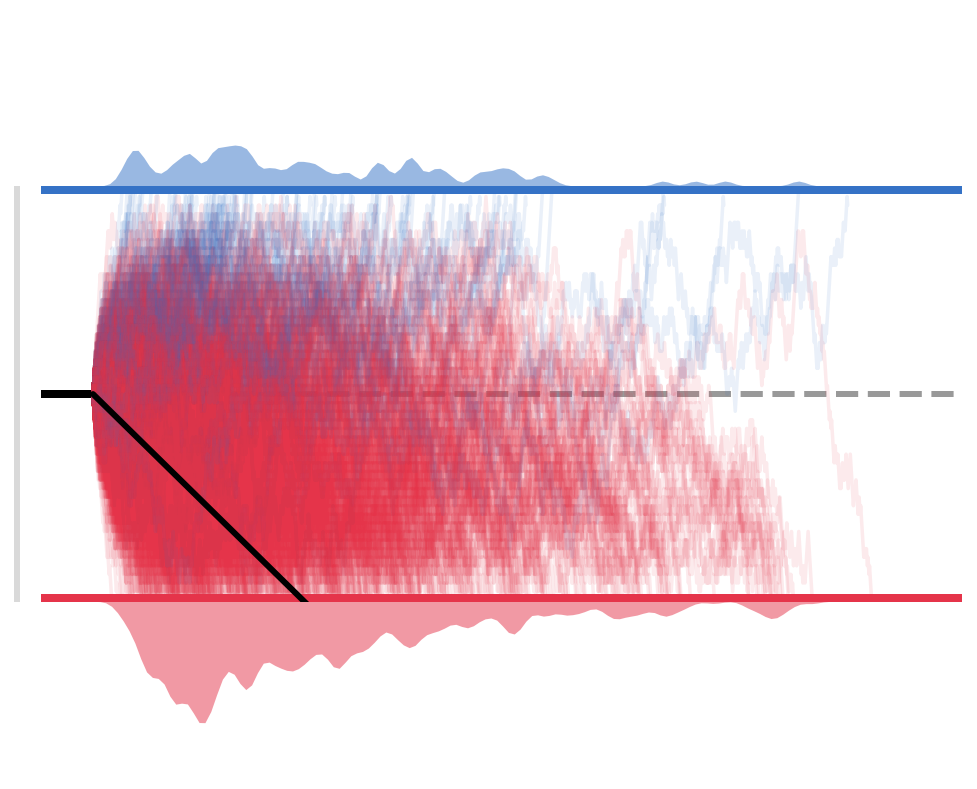

In [106]:
ax = vis.plot_ddm_sims(df2, parameters2, traces=trace2, plot_v=True)

# Compare $v$ and $v_2$ RTs 

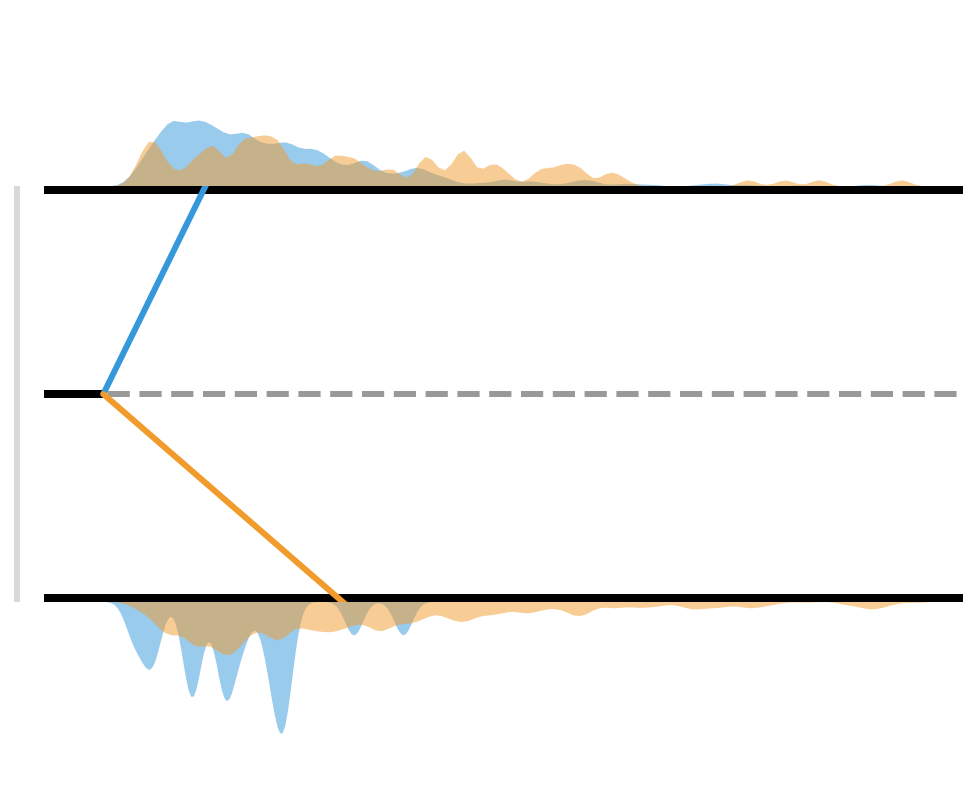

In [105]:
ax = vis.compare_drift_effects([df, df2], [parameters, parameters2])